In [1]:
import numpy as np
import BSM
import AssetModels

In [ ]:
import numpy as np
from scipy.stats import norm

def simulate_stock(S0, r, sigma, T, paths):
    """Simulates final stock price using GBM"""
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T)
    Z = np.random.normal(0, 1, paths)
    ST = S0 * np.exp(drift + diffusion * Z)
    return ST

def black_scholes(S0, K, T, r, sigma, option_type='call'):
    """Prices a European option using Black-Scholes"""
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        price = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:  # put
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    
    return price

def simulate_portfolio_pnl(
    # Stock simulation parameters
    S0, r, sigma_stock, T, paths,
    # Stock position
    stock_qty=0,
    # List of option positions
    options=None  # [{'qty': int, 'K': float, 'sigma': float, 'type': 'call'/'put'}, ...]
):
    """
    Simulates portfolio PnL with stock and multiple options.
    Each option can have its own strike, implied vol, and type.
    
    options: list of dicts, each containing:
        - qty: position size (positive for long, negative for short)
        - K: strike price
        - sigma: implied volatility for pricing
        - type: 'call' or 'put'
    """
    # Initialize options list if None
    options = options or []
    
    # Simulate final stock prices
    final_prices = simulate_stock(S0, r, sigma_stock, T, paths)
    
    # Calculate initial position costs
    initial_stock_cost = stock_qty * S0
    
    # Calculate initial options cost and final payoffs
    initial_options_cost = 0
    final_options_value = np.zeros(paths)
    
    for option in options:
        qty = option['qty']
        K = option['K']
        sigma = option['sigma']
        option_type = option['type']
        
        # Initial option price
        price = black_scholes(S0, K, T, r, sigma, option_type)
        initial_options_cost += qty * price
        
        # Final payoff
        if option_type == 'call':
            payoff = np.maximum(final_prices - K, 0)
        else:  # put
            payoff = np.maximum(K - final_prices, 0)
        
        final_options_value += qty * payoff
    
    # Initial cash grows at risk-free rate
    initial_cost = -(initial_stock_cost + initial_options_cost)
    final_cash = initial_cost * np.exp(r * T)
    
    # Calculate final stock value
    final_stock_value = stock_qty * final_prices
    
    # Calculate total PnL
    pnl = final_cash + final_stock_value + final_options_value
    
    return pnl

# Example usage
if __name__ == "__main__":
    # Basic parameters
    S0 = 100          # Initial stock price
    r = 0.05          # Risk-free rate
    sigma_stock = 0.25 # True volatility for stock simulation
    T = 1             # Time horizon
    paths = 100000     # Number of simulations
    
    # Stock position
    stock_qty = -   # Long 100 shares
    
    # Multiple option positions
    options = [
        # Long 10 OTM calls with high implied vol
        {
            'qty': 1,
            'K': 100,
            'sigma': 0.2,  # Higher implied vol
            'type': 'call'
        },
        # Short 5 far OTM calls with even higher vol
        {
            'qty': -1,
            'K': 110,
            'sigma': 0.30,
            'type': 'call'
        }
    ]
    
    # Run simulation
    pnl = simulate_portfolio_pnl(
        S0=S0, r=r, sigma_stock=sigma_stock, T=T, paths=paths,
        stock_qty=stock_qty, options=options
    )
    
    print(f"\nPnL Statistics:")
    print(f"Mean: ${np.mean(pnl):,.2f}")
    print(f"Std Dev: ${np.std(pnl):,.2f}")
    print(f"Min: ${np.min(pnl):,.2f}")
    print(f"Max: ${np.max(pnl):,.2f}")


PnL Statistics:
Mean: $4.10
Std Dev: $7.84
Min: $-9.27
Max: $34.66


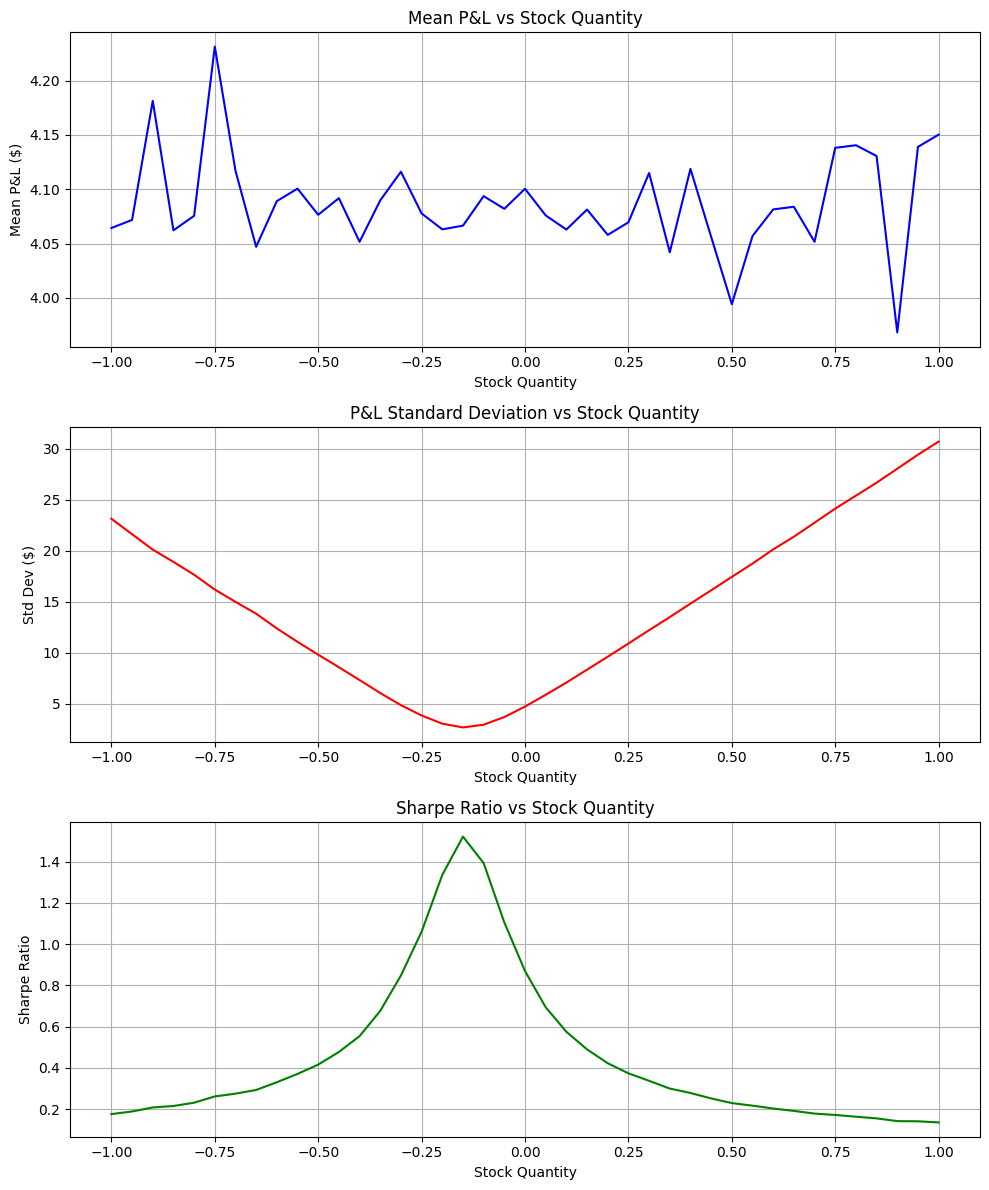


Optimal stock quantity (best Sharpe): -0.150
With Sharpe ratio: 1.521
Mean P&L: $4.07
Std Dev: $2.67


In [96]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# [Previous simulate_stock, black_scholes, and simulate_portfolio_pnl functions stay the same]

# Basic parameters
S0 = 100
r = 0.05
sigma_stock = 0.25
T = 1
paths = 100000

# Option strategy - fixed for all simulations
options = [
    {'qty': 1, 'K': 100, 'sigma': 0.2, 'type': 'call'},
    {'qty': -1, 'K': 110, 'sigma': 0.30, 'type': 'call'}
]

# Generate stock quantities from -1 to 1
stock_quantities = np.linspace(-1, 1, 41)  # 41 points for nice granularity
means = []
stds = []
sharpes = []

# Run simulation for each quantity
for stock_qty in stock_quantities:
    pnl = simulate_portfolio_pnl(
        S0=S0, r=r, sigma_stock=sigma_stock, T=T, paths=paths,
        stock_qty=stock_qty, options=options
    )
    
    mean_pnl = np.mean(pnl)
    std_pnl = np.std(pnl)
    sharpe = mean_pnl / std_pnl if std_pnl != 0 else 0
    
    means.append(mean_pnl)
    stds.append(std_pnl)
    sharpes.append(sharpe)

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Mean P&L plot
ax1.plot(stock_quantities, means, 'b-')
ax1.set_title('Mean P&L vs Stock Quantity')
ax1.set_xlabel('Stock Quantity')
ax1.set_ylabel('Mean P&L ($)')
ax1.grid(True)

# Standard Deviation plot
ax2.plot(stock_quantities, stds, 'r-')
ax2.set_title('P&L Standard Deviation vs Stock Quantity')
ax2.set_xlabel('Stock Quantity')
ax2.set_ylabel('Std Dev ($)')
ax2.grid(True)

# Sharpe Ratio plot
ax3.plot(stock_quantities, sharpes, 'g-')
ax3.set_title('Sharpe Ratio vs Stock Quantity')
ax3.set_xlabel('Stock Quantity')
ax3.set_ylabel('Sharpe Ratio')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print optimal points
best_sharpe_idx = np.argmax(sharpes)
best_stock_qty = stock_quantities[best_sharpe_idx]
print(f"\nOptimal stock quantity (best Sharpe): {best_stock_qty:.3f}")
print(f"With Sharpe ratio: {sharpes[best_sharpe_idx]:.3f}")
print(f"Mean P&L: ${means[best_sharpe_idx]:.2f}")
print(f"Std Dev: ${stds[best_sharpe_idx]:.2f}")

In [ ]:
BSM.delta(S0=100, K=100, r=0.05, sigma=0.25, T=1, option_type='call') - BSM.delta(S0=100, K=110, r=0.05, sigma=0.25, T=1, option_type='call')

0.14983444253631772

: 

In [6]:
S0 = 100
K = 100
r = 0.05
sigma = 0.25
T = 1
option_type = 'call'

BSM.delta(S0, K, r, sigma, T, option_type)
BSM.gamma(K=K, r=r, sigma=sigma, T=T, S0=S0)
BSM.vega(S0, K, r, sigma, T)

8.796052277544488

u: 1.4477
d: 0.6907


In [1]:
import numpy as np

n_shares = 20000
S0 = 152
r = 0.011
sigma = 0.37
T = 3
n_periods = 3

# Calculate parameters
dt = T / n_periods
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
u_bar = 1.25
d_bar = 1 / u_bar

print(f"u: {u:.4f}")
print(f"d: {d:.4f}")

# Initialize trees
tree = np.zeros((n_periods + 1, n_periods + 1))
tree_bar = np.zeros((n_periods + 1, n_periods + 1))

# Set initial price
tree[0, 0] = S0
tree_bar[0, 0] = S0

# Fill trees
for i in range(1, n_periods + 1):
    for j in range(i + 1):
        if j == 0:
            # Up move
            tree[j, i] = tree[j, i - 1] * u
            tree_bar[j, i] = tree_bar[j, i - 1] * u_bar
        else:
            # Down move
            tree[j, i] = tree[j - 1, i - 1] * d
            tree_bar[j, i] = tree_bar[j - 1, i - 1] * d_bar

# Print results
print("Tree:")
print(tree)
print("\nTree (u_bar):")
print(tree_bar)


u: 1.4477
d: 0.6907
Tree:
[[152.         220.05566143 318.5821982  461.22247595]
 [  0.         104.99161826 152.         220.05566143]
 [  0.           0.          72.52131516 104.99161826]
 [  0.           0.           0.          50.09296208]]

Tree (u_bar):
[[152.    190.    237.5   296.875]
 [  0.    121.6   152.    190.   ]
 [  0.      0.     97.28  121.6  ]
 [  0.      0.      0.     77.824]]


In [10]:
import random
import math

price_per_share = 152
rf = .011
sigma = .37

u =  1.25
d = 1/u
S0 = price_per_share
# S11 = S0 * u
# S12 = S0 * d
# S21 = S11 * u
# S22 = S11 * d
# S23 = S12 * d

exp_ret = .12
# p = (S0 * math.exp(exp_ret) - S12) / (S11 - S12) * 100
# q = (S0 * math.exp(rf) - S12) / (S11 - S12) * 100
# p, q

In [12]:

S11 = 199.11
S12 = 116.03
S21 = 260.83
S22 = 152.00
S23 = 88.58

p = (S0 * math.exp(exp_ret) - S12) / (S11 - S12)

q = (S0 * math.exp(rf) - S12) / (S11 - S12)

def payoff(s1: float, s2: float, strike: float = S0):
  return max((s1 + s2)/2 - strike, 0)

exp_payoff = q * q * payoff(s1=S11, s2=S21)
exp_payoff += q * (1 - q) * payoff(s1=S11, s2=S22)
exp_payoff += (1 - q) * q * payoff(s1=S12, s2=S22)
exp_payoff += (1 - q) * (1 - q) * payoff(s1=S12, s2=S23)
option_px = math.exp(-rf * 2) * exp_payoff
option_px

21.375416470966336

In [ ]:
<problem url_name="165dce34ee8f404f8f9896ba797ca0f6" copied_from_block="block-v1:MITx+15.435x+2T2022+type@problem+block@165dce34ee8f404f8f9896ba797ca0f6" upstream="null">
<script type="text/python">

"""
Notes to future editors:
  1) Randomization on EdX by student ID is imperfect, hence the need for the seednum calculation
  2) Rounding numbers also leads to strange errors, hence the need for the fround function
"""

### BOILERPLATE CODE ###
import math
import random
from typing import Tuple

# random seed according to student id
try:
  seednum = int(anonymous_student_id, 16)
except:
  seednum = 925668404
random.seed(seednum)

def fround(x: float) -&gt; float:
  """Corrects Python's rounding approach
  """
  xfrac, xint = math.modf(x)
  return xint + round(xfrac, 12)

def ffloat(x: float, n: int) -&gt; float:
  """Corrects Python's float trailing bias
  """
  return float(f"{fround(x):.{n}f}")

def fdisp(x: float, n: int) -&gt; str:
  """Returns n-digit display format
  """
  return f"{fround(x):,.{n}f}"

def f(x: float, n: int) -&gt; Tuple[float, str]:
  """Returns corrected float and display string of result
  """
  return ffloat(x, n), fdisp(x, n)


### PROBLEM CODE ###
shares_outstanding = ffloat(2e4, 0)
shares_outstanding_disp = f"{shares_outstanding:,.0f}"
price_per_share, price_per_share_disp = f(random.randint(145, 155), 2)
rf = ffloat(random.random()/50 + 0.01, 3)
rf_disp = f"{rf:.2%}"
sigma = ffloat(random.random()/10 + 0.2, 2)
sigma_disp = f"{sigma:.2%}"

u =  math.exp(sigma)
d = 1/u
S0 = price_per_share
S11 = S0 * u
S12 = S0 * d
S21 = S11 * u
S22 = S11 * d
S23 = S12 * d

u_disp =  fdisp(u, 4)
d_disp = fdisp(d, 4)
S0_disp = f"${S0:.2f}"
S11_disp = f"${S11:.2f}"
S12_disp = f"${S12:.2f}"
S21_disp = f"${S21:.2f}"
S22_disp = f"${S22:.2f}"
S23_disp = f"${S23:.2f}"

exp_ret = ffloat(random.random()/50 + 0.08, 2)
exp_ret_disp = f"{exp_ret:.2%}"
p = (S0 * math.exp(exp_ret) - S12) / (S11 - S12)
p_disp = f"{p:.2%}"

q = (S0 * math.exp(rf) - S12) / (S11 - S12)
q_disp = f"{q:.2%}"

def payoff(s1: float, s2: float, strike: float = S0) -&gt; float:
  return max((s1 + s2)/2 - strike, 0)

exp_payoff = q * q * payoff(s1=S11, s2=S21)
exp_payoff += q * (1 - q) * payoff(s1=S11, s2=S22)
exp_payoff += (1 - q) * q * payoff(s1=S12, s2=S22)
exp_payoff += (1 - q) * (1 - q) * payoff(s1=S12, s2=S23)
option_px = math.exp(-rf * 2) * exp_payoff

</script>
  <p>
    Suppose the values on the tree are as below (note: this tree is distinct from the one above and the values will likely differ from your previous answers):
    \[
      \begin{array}{lllll}
      \hline
      t=0   &amp;          &amp; t=1   &amp;          &amp; t=2    \\ \hline
      &amp;          &amp;       &amp;          &amp; $S21_disp \\
      &amp;          &amp;       &amp; \nearrow &amp;        \\
      &amp;          &amp; $S11_disp &amp;          &amp;        \\
      &amp; \nearrow &amp;       &amp; \searrow &amp;        \\
      $S0_disp &amp;          &amp;       &amp;          &amp; $S22_disp \\
      &amp; \searrow &amp;       &amp; \nearrow &amp;        \\
      &amp;          &amp; $S12_disp &amp;          &amp;        \\
      &amp;          &amp;       &amp; \searrow &amp;        \\
      &amp;          &amp;       &amp;          &amp; $S23_disp \\ \hline
      \end{array}
    \]
    On this tree, the physical probablity of an up move is $p_disp and the risk-neutral probability of an up move is $q_disp. The risk-free rate is still $rf_disp per annum on a continuously compounded basis.
  </p>
  <p>
    (d) Your client would like to buy an Asian call option on the stock with a strike price of $$price_per_share_disp and that expires in 2 years. It can only be exercised at expiration. Its payoff will be any positive difference between the average of the realized stock prices at years 1 and 2, and the strike price. Use the tree to estimate the fair price of this option.
  </p>
  <numericalresponse answer="$option_px">
    <responseparam type="tolerance" default="3%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
</problem>



(10.450583572185565, 14.231254785985819)

In [ ]:
# <problem url_name="0cb67fedcdf54e658895116d0e775385" copied_from_block="block-v1:MITx+15.435x+2T2022+type@problem+block@0cb67fedcdf54e658895116d0e775385" upstream="null">
# <script type="text/python">

# """
# Notes to future editors:
#   1) Randomization on EdX by student ID is imperfect, hence the need for the seednum calculation
#   2) Rounding numbers also leads to strange errors, hence the need for the fround function
# """

# ### PROBLEM CODE ###
# choices = [[]] * 4
# choices[0] = ["A long position in a put option and a long position in a call option", False]
# choices[1] = ["A long position in call options plus a short position in the underlying stock", False]
# choices[2] = ["A short position in call options plus a short position in the underlying stock", True]
# choices[3] = ["A long position in put options and a long position in the underlying stock", False]
# random.shuffle(choices)

# for i in range(len(choices)):
#   for j in range(len(choices[i])):
#     exec(f"choices{i}{j} = choices[i][j]")

# </script>
# <choiceresponse partial_credit="EDC">
#   <label>Which of these portfolios could NOT be delta-neutral (i.e., zero-delta)? (Indicate all that are correct; there may be multiple correct answers. No explanation needed.)</label>
#   <checkboxgroup>
#     <choice correct="$choices01">$choices00</choice>
#     <choice correct="$choices11">$choices10</choice>
#     <choice correct="$choices21">$choices20</choice>
#     <choice correct="$choices31">$choices30</choice>
#     <choice correct="false">All of the above could be delta neutral</choice>
#   </checkboxgroup>
# </choiceresponse>
# </problem>



In [ ]:
  # </p>
  # <table width="100%" cellpadding="4" cellspacing="3">
  #   <tr align="center">
  #     <th colspan="1"/>
  #     <th colspan="1">Prices today</th>
  #     <th colspan="1">Default probability</th>
  #     <th colspan="1">Recovery if default</th>
  #   </tr>
  #   <tr>
  #     <td>Bond 1</td>
  #     <td>$$px_1_disp</td>
  #     <td>$pr_default_1_disp</td>
  #     <td>$$recovery_1_disp</td>
  #   </tr>
  #   <tr>
  #     <td>Bond 2</td>
  #     <td>$$px_2_disp</td>
  #     <td>$pr_default_2_disp</td>
  #     <td>$$recovery_2_disp</td>
  #   </tr>
  #   <tr>
  #     <td>Bond 3</td>
  #     <td>$$px_3_disp</td>
  #     <td>$pr_default_3_disp</td>
  #     <td>$$recovery_3_disp</td>
  #   </tr>
  # </table>
  # <p>

In [17]:
from scipy.stats import norm

def done(S,K,T,r,delta,sigma):
  """calculate done
  """
  return (math.log(S/K)+(r-delta+sigma**2/2.)*T)/(sigma*math.sqrt(T))

def dtwo(S,K,T,r,delta,sigma):
  """calculate dtwo
  """
  return done(S,K,T,r,delta,sigma)-sigma * math.sqrt(T)

def call(S,K,T,r,delta,sigma):
  """calculate call
  """
  return S*math.exp(-delta*T)*norm.cdf(done(S,K,T,r,delta,sigma))-K*math.exp(-r*T)*norm.cdf(dtwo(S,K,T,r,delta,sigma))

def put(S,K,T,r,delta,sigma):
  """calculate put
  """
  return K*math.exp(-r*T)*norm.cdf(-dtwo(S,K,T,r,delta,sigma))-S*math.exp(-delta*T)*norm.cdf(-done(S,K,T,r,delta,sigma))

def option(S,K,T,r,delta,sigma,iscall=True):
  """calculate put
  """
  if iscall:
    return call(S,K,T,r,delta,sigma)
  else:
    return put(S,K,T,r,delta,sigma)

def vega(S,K,T,r,delta,sigma):
  """calculate vega
  """
  return S*math.sqrt(T)*norm.pdf(done(S,K,T,r,delta,sigma))

def impvol(S,K,T,r,delta,optionprice,iscall=True,tol=1e-5,maxiter=1e3):
  """calculate implied volatility
  """
  sigma = .5
  for i in range(int(maxiter)):
    diff = optionprice - option(S,K,T,r,delta,sigma,iscall)
    if abs(diff) < tol:
      break
    sigma = sigma + diff/vega(S,K,T,r,delta,sigma)
  return sigma

In [42]:
S = 100
r = 0.0202
delta = 0.0131
T = 2

K_1 = 95
K_2 = 100
K_3 = 105

C_1 = 12.444149
C_2 = 12.117957
C_3 = 10.615304

sigma_1 = impvol(S, K_1, T, r, delta, C_1)
sigma_2 = impvol(S, K_2, T, r, delta, C_2)
sigma_3 = impvol(S, K_3, T, r, delta, C_3)

sigma_1, sigma_2, sigma_3


(0.17000002260182606, 0.20999997845703577, 0.21999984094457814)

In [20]:
import BSM

BSM.price(S0=S0, K=K_1, T=T, r=r, sigma=sigma_1, option_type='call') 

12.300007939924456

In [ ]:
<problem url_name="cffaeba587df404fb4006459995942d6" copied_from_block="block-v1:MITx+15.435x+1T2021+type@problem+block@cffaeba587df404fb4006459995942d6">
<script type="text/python">

import random
import math

### Function Block

# random seed according to student id
seednum = [i for i in anonymous_student_id if i.isdigit()]

try:
  seednum = int("".join(seednum))
except:
  seednum = 19631104
random.seed(seednum)

def fround(x):
    #This function corrects Python rounding approach.
    #I (Peter Pham) removed the use of the numpy library to decrease the potential HTML error occurences and to future-proof any backwards incompatibility issues with library updates, which happened in other courses as numpy functions were rendered non-functional with numpy_financial.
  xdec = x - int(x)
  xint = int(x)
  return xint + round(xdec, 12)

def ffloat2(x):
  """This function corrects Python float trailing bias.
  """
  return float( "{:.2f}".format(fround(x)) )

def fdisp2(x):
  """This function returns the n-digit display format.
  """
  return "{:.2f}".format(fround(x))

def ffloat4(x):
  """This function corrects Python float trailing bias.
  """
  return float( "{:.4f}".format(fround(x)) )

def fdisp4(x):
  """This function returns the n-digit display format.
  """
  return "{:.4f}".format(fround(x))

def ffloat6(x):
  """This function corrects Python float trailing bias.
  """
  return float( "{:.6f}".format(fround(x)) )

def fdisp6(x):
  """This function returns the n-digit display format.
  """
  return "{:.6f}".format(fround(x))

def f2(x):
  """This function returns the float and string of given.
  """
  return ffloat2(x),fdisp2(x)

def f4(x):
  """This function returns the float and string of result.
  """
  return ffloat4(x),fdisp4(x)

def f6(x):
  """This function returns the float and string of result.
  """
  return ffloat6(x),fdisp6(x)

### Randomization Block

sigma1,sigma1_disp = f2(random.uniform(0.15,0.17))
sigma2,sigma2_disp = f2(sigma1 + 0.04)
sigma3,sigma3_disp = f2(sigma1 + 0.05)

### Computation Block

S = 100
K1,K2 = 100,110
r = 5.00/100
delta = 0/100
T = 1

from scipy.stats import norm

def done(S,K,T,r,delta,sigma):
  """calculate done
  """
  return (math.log(S/K)+(r-delta+sigma**2/2.)*T)/(sigma*math.sqrt(T))

def dtwo(S,K,T,r,delta,sigma):
  """calculate dtwo
  """
  return done(S,K,T,r,delta,sigma)-sigma*math.sqrt(T)

def call(S,K,T,r,delta,sigma):
  """calculate call
  """
  return S*math.exp(-delta*T)*norm.cdf(done(S,K,T,r,delta,sigma))-K*math.exp(-r*T)*norm.cdf(dtwo(S,K,T,r,delta,sigma))

def put(S,K,T,r,delta,sigma):
  """calculate put
  """
  return K*math.exp(-r*T)*norm.cdf(-dtwo(S,K,T,r,delta,sigma))-S*math.exp(-delta*T)*norm.cdf(-done(S,K,T,r,delta,sigma))

c1 = call(S,K1,T,r,delta,sigma1)
c2 = call(S,K2,T,r,delta,sigma2)

c1,c1_disp = f6(c1)
c2,c2_disp = f6(c2)

def vega(S,K,T,r,delta,sigma):
  """calculate vega
  """
  return S*math.sqrt(T)*norm.pdf(done(S,K,T,r,delta,sigma))

def impvol(S,K,T,r,delta,optionprice,tol=1e-5,maxiter=1e3):
  """calculate implied volatility
  """
  sigma = .5
  for i in range(int(maxiter)):
    diff = optionprice - call(S,K,T,r,delta,sigma)
    if abs(diff) &lt; tol:
      break
    sigma = sigma + diff/vega(S,K,T,r,delta,sigma)
  return sigma

sigma1 = impvol(S,K1,T,r,delta,c1)
sigma2 = impvol(S,K2,T,r,delta,c2)

### Solution Block

sol_a1,sol_a1_disp = f6(sigma1)
sol_a2,sol_a2_disp = f6(sigma2)


</script>

<p>
Two European call options on the same underlying stockhave the following characteristics: Current Stock Price \( S \) = \$100, Continuously-compounded Risk-free Rate \( r \) = 5\% per annum, Time to Expiration \( T \) = 1 year.  
Call A: Strike Price \(K_A\) = \$100,  Current Option Price \(C_A\)  = $$c1_disp;
Call B: Strike Price \(K_B\) = \$110,  Current Option Price \(C_B\)  = $$c2_disp.
</p>

<br/>

<p>
Based on this information, calculate the implied volatility for Options A and B. Write your answers in decimal numbers.
</p>

<numericalresponse answer="$sol_a1_disp"><p>\( \sigma_{1} \)</p>

<responseparam type="tolerance" default="0.005" name="tol" description="Numerical Tolerance"/>
<textline size="10" trailing_text=""/>

</numericalresponse>

<numericalresponse answer="$sol_a2_disp"><p>\( \sigma_{2} \)</p>

<responseparam type="tolerance" default="0.005" name="tol" description="Numerical Tolerance"/>
<textline size="10" trailing_text=""/>

<solution><div class="detailed-solution"><p>Explanation</p>

<p>
Plugging the numbers gives the answers shown.
</p>

</div></solution>

</numericalresponse>

</problem>
  


In [ ]:
import numpy as np
from scipy.stats import norm
import math

### Function Block

def fround(x):
    """This function corrects Python rounding approach."""
    xdec, xint = np.modf(x)
    return xint + np.round(xdec, 12)

def ffloat2(x):
    """This function corrects Python float trailing bias."""
    return float("{:.2f}".format(fround(x)))

def fdisp2(x):
    """This function returns the n-digit display format."""
    return "{:.2f}".format(fround(x))

def ffloat6(x):
    """This function corrects Python float trailing bias."""
    return float("{:.6f}".format(fround(x)))

def fdisp6(x):
    """This function returns the n-digit display format."""
    return "{:.6f}".format(fround(x))

def fgiven(x):
    """This function returns the float and string of given."""
    return ffloat2(x), fdisp2(x)

def fresult(x):
    """This function returns the float and string of result."""
    return ffloat6(x), fdisp6(x)

def flresult(x):
    """This function returns the float and string of list of results."""
    return [ffloat6(xi) for xi in x], [fdisp6(xi) for xi in x]

### Computation Block

def done(S, K, T, r, delta, sigma):
    """calculate d1"""
    return (math.log(S / K) + (r - delta + sigma**2 / 2.) * T) / (sigma * math.sqrt(T))

def dtwo(S, K, T, r, delta, sigma):
    """calculate d2"""
    return done(S, K, T, r, delta, sigma) - sigma * math.sqrt(T)

def call(S, K, T, r, delta, sigma):
    """calculate call price"""
    return S * math.exp(-delta * T) * norm.cdf(done(S, K, T, r, delta, sigma)) - K * math.exp(-r * T) * norm.cdf(dtwo(S, K, T, r, delta, sigma))

def vega(S, K, T, r, delta, sigma):
    """calculate vega"""
    return S * math.sqrt(T) * norm.pdf(done(S, K, T, r, delta, sigma))

def impvol(S, K, T, r, delta, optionprice, tol=1e-5, maxiter=1e3):
    """calculate implied volatility"""
    sigma = 0.2  # Initial guess
    for i in range(int(maxiter)):
        diff = optionprice - call(S, K, T, r, delta, sigma)
        if abs(diff) < tol:
            break
        sigma = sigma + diff / vega(S, K, T, r, delta, sigma)
    return sigma

### Inputs for Options A and B
S, S_disp = fgiven(100)  # Stock price
r, r_disp = fgiven(0.05)  # Risk-free rate
T = 1  # Time to expiration (1 year)

def calc_option(S, K, option_price):
    """Wrapper to calculate implied volatility for an option."""
    return impvol(S, K, T, r, 0, option_price) * 100

# Option A
KA, KA_disp = fgiven(100)  # Strike price for Option A
CA, CA_disp = fgiven(9.67)  # Current price for Option A

# Option B
KB, KB_disp = fgiven(110)  # Strike price for Option B
CB, CB_disp = fgiven(8.21)  # Current price for Option B

# Implied Volatilities
IVA = calc_option(S, KA, CA)
IVB = calc_option(S, KB, CB)

sol_a, sol_a_disp = fresult(IVA)
sol_b, sol_b_disp = fresult(IVB)

### HTML Question Block

html_question = '''
<problem url_name="implied_volatility_calculation">
  <script type="text/python">
{code}
  </script>
  <p>
Two European call options on the same underlying stock have the following characteristics:
Current Stock Price (S₀) = $100, Continuously-compounded Risk-free Rate (r) = 5% per annum, Time to Expiration (T) = 1 year.
  </p>
  <p>
Call A: Strike Price (KA) = $100, Current Option Price (CA) = $9.67;<br/>
Call B: Strike Price (KB) = $110, Current Option Price (CB) = $8.21.
  </p>
  <p>
Calculate the implied volatilities for Options A and B.<br/>
[IV(A) = 17.9132%, IV(B) = 25.4609%]
  </p>
  <numericalresponse answer="{sol_a_disp}">
    <p>Implied Volatility for Option A:</p>
    <responseparam type="tolerance" default="0.05" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="%"/>
  </numericalresponse>
  <numericalresponse answer="{sol_b_disp}">
    <p>Implied Volatility for Option B:</p>
    <responseparam type="tolerance" default="0.05" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="%"/>
  </numericalresponse>
  <p>
Which of the following strategies would you use to set up a position that would be profitable if the implied volatilities of the two options were to converge over the next week?
  </p>
  <p>
  <ol>
    <li>Buy Option A, sell Option B</li>
    <li>Sell Option A, buy Option B</li>
    <li>Buy both Option A and Option B</li>
    <li>Sell both Option A and Option B</li>
    <li>Buy Option A, sell Underlying Asset</li>
    <li>Sell Option B, buy Underlying Asset</li>
  </ol>
  </p>
</problem>
'''.format(code=repr(open(__file__).read()), sol_a_disp=sol_a_disp, sol_b_disp=sol_b_disp)

### Solution Block

print("Implied Volatility for Option A:", sol_a_disp, "%")
print("Implied Volatility for Option B:", sol_b_disp, "%")

print("HTML Question Block:")
print(html_question)


In [ ]:
K = 100
T = 3.25
r = 0.04
q = 0.00
S0 = 95
sigma = 0.12
type = 'put'

BSM.price(S0, K, T, r, sigma, type, q)

0.0006191375304381037

In [7]:
K = 10
T = 7
r = 0.0323
q = 0.02
S0 = 10
sigma = 0.15

BSM.delta(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, option_type='call')

0.6610692090727709

In [8]:
def bond_duration_and_convexity(N, face, fr, cpn, yld):
    # Calculate the number of periods
    M = int(N * fr)
    # Adjust coupon rate to payment frequency
    coupon_payment = (cpn * face) / fr
    # Adjust yield to payment frequency
    if fr == 2:
        yield_per_period = yld / fr
    else:
        yield_per_period = (1 + yld/2)**2 - 1
    

    # Initialize variables for price, duration, and convexity
    bond_price = 0
    macaulay_duration = 0
    convexity = 0

    # Compute cash flows and add to price, duration, and convexity
    for t in range(1, M + 1):
        cash_flow = coupon_payment if t < M else (coupon_payment + face)

        bond_price += cash_flow / (1 + yield_per_period) ** t
        macaulay_duration += (t/fr) * cash_flow / (1 + yield_per_period) ** t
        convexity += (t/fr) * ((t/fr) + 1) * cash_flow / (1 + yield_per_period) ** t / ((1 + yield_per_period) ** 2)

    # Final adjustments for Macaulay Duration and Convexity
    macaulay_duration /= bond_price
    convexity /= bond_price * (1 + yield_per_period) ** 2

    # Calculate Modified Duration
    modified_duration = macaulay_duration / (1 + yield_per_period)

    return bond_price, macaulay_duration, modified_duration, convexity

# Example Usage:
N = 5
face = 100
fr = 1
cpn = 0.06
yld = 0.09

price, macaulay_duration, modified_duration, convexity = bond_duration_and_convexity(N, face, fr, cpn, yld)

print(f"Bond Price: {price:.2f}")
print(f"Macaulay Duration: {macaulay_duration:.4f}")
print(f"Modified Duration: {modified_duration:.4f}")
print(f"Convexity: {convexity:.4f}")

Bond Price: 87.61
Macaulay Duration: 4.4235
Modified Duration: 4.0507
Convexity: 17.8872


In [9]:
def bond_duration_and_convexity(N, face, fr, cpn, yld):
    M = int(N * fr)
    coupon_payment = (cpn * face) / fr
    if fr == 2:
        yield_per_period = yld / fr
    else:
        yield_per_period = (1 + yld / 2) ** 2 - 1

    # Handle fractional period and initial offset
    fractional_period = N % (1 / fr)  # Time to first payment in years
    offset_time = fractional_period * fr  # Offset in terms of payment periods

    bond_price = 0
    macaulay_duration = 0
    convexity = 0

    if fractional_period > 0:    
        bond_price += coupon_payment / (1 + yield_per_period) ** offset_time
        macaulay_duration += offset_time * coupon_payment / (1 + yield_per_period) ** offset_time
        convexity += offset_time * (offset_time + 1) * coupon_payment / (1 + yield_per_period) ** offset_time / ((1 + yield_per_period) ** 2)

    for t in range(1, M + 1):
        cash_flow = coupon_payment if t < M else (coupon_payment + face)
        adjusted_time = t + offset_time  # Adjust time by fractional offset

        bond_price += cash_flow / (1 + yield_per_period) ** adjusted_time
        macaulay_duration += (adjusted_time / fr) * cash_flow / (1 + yield_per_period) ** adjusted_time
        convexity += (adjusted_time / fr) * ((adjusted_time / fr) + 1) * cash_flow / (1 + yield_per_period) ** adjusted_time / ((1 + yield_per_period) ** 2)

    macaulay_duration /= bond_price
    convexity /= bond_price * (1 + yield_per_period) ** 2

    modified_duration = macaulay_duration / (1 + yield_per_period)

    return bond_price, macaulay_duration, modified_duration, convexity

# Example Usage:
N = 5.5           # Time to maturity (years)
face = 100      # Face value of the bond
fr = 2          # Semiannual payments
cpn = 0.06      # Coupon rate (6%)
yld = 0.09      # Yield to maturity (9%)

price, macaulay_duration, modified_duration, convexity = bond_duration_and_convexity(N, face, fr, cpn, yld)

print(f"Bond Price: {price:.2f}")
print(f"Macaulay Duration: {macaulay_duration:.3f}")
print(f"Modified Duration: {modified_duration:.3f}")
print(f"Convexity: {convexity:.3f}")

Bond Price: 87.21
Macaulay Duration: 4.702
Modified Duration: 4.500
Convexity: 24.377


<Axes: title={'center': 'Final Profits Distribution'}, ylabel='Frequency'>

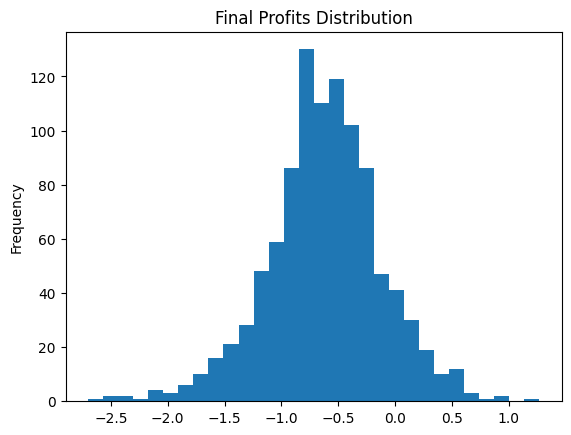

In [ ]:

def dh_path(S0, K, T, r, sigma, option_type, mu, dt, option_pos, path=None, sigma_h=None, sigma_a=None):

    S, t, sigma_t = GARCH_with_jumps(S0, mu, sigma, kappa, sigma_bar, alpha, T, dt, 
                                         jump_intensity, jump_mean, jump_std)
    option_price = price(S0, K, T, r, sigma, option_type)
    N = len(S)
    T_i = T - t

    d1_vals = np.where(
        T_i[:-1] == 0,
        np.where(S[:-1] > K, float('inf'), np.where(S[:-1] < K, float('-inf'), 0.0)),
        (np.log(S[:-1] / K) + (r + 0.5 * sigma_t ** 2) * T_i[:-1]) / (sigma_t * np.sqrt(T_i[:-1]))
    )
    d1_vals = np.append(
        d1_vals, 
        float('inf') if S[-1] > K else float('-inf') if S[-1] < K else 0.0
    )

    delta_vals = stats.norm.cdf(d1_vals) if option_type == 'call' else stats.norm.cdf(d1_vals) - 1

    delta_diff = np.diff(delta_vals, prepend=0)
    cashflows = delta_diff * option_pos * S
    comp_factors = np.exp(r * (T - t)) - 1
    interests = cashflows * comp_factors
    pnl_path = np.cumsum(interests + cashflows)

    if option_type == 'call' and S[-1] > K:
        pnl_path[-1] -= K * option_pos
    elif option_type == 'put' and S[-1] < K:
        pnl_path[-1] += K * option_pos

    pnl_path -= option_price * option_pos
    pnl_path *= np.exp(-r * T)

    return pnl_path

S0 = 100
mu = 0.08
sigma0_gj = 0.1
kappa = 0.2        # Mean reversion coefficient
sigma_bar = 0.15    # Long term vol
sigma_bar_gj = 0.1
alpha = 0.1        # GARCH reaction coefficient
T = 1.0
dt = 1/252
jump_intensity = 4  # Average of 10 jumps per unit time
jump_mean =  0.0  # Mean jump magnitude (log-normal parameter)
jump_std_g = 0.1      # Std dev of jump magnitude
r = 0.05
K = 100
option_type = 'put'
option_pos = -1
nsims = 1000

import pandas as pd

final_profits = []
for _ in range(num_paths):
    results = dh_path(S0=S0, K=K, T=T, r=r, sigma=sigma, option_type=option_type, mu=mu, dt=dt, option_pos=option_pos)
    final_profits.append(results[-1])

pd.DataFrame(final_profits).plot(kind='hist', bins=30, title='Final Profits Distribution', legend=False)



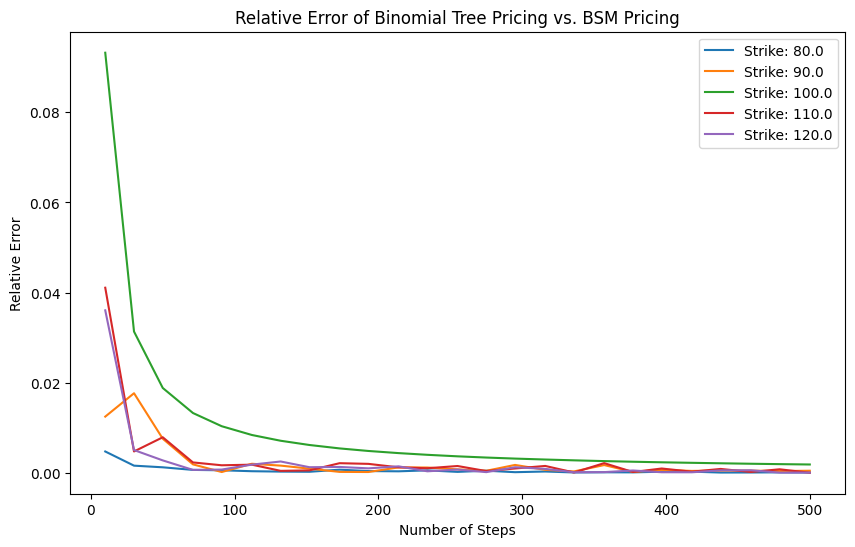

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# def print_tree(tree):
#     n = tree.shape[1] - 1
#     for i in range(n + 1):
#         print(" " * (n - i) * 8, end="")
#         for j in range(i + 1):
#             print(f"{tree[j, i]:12.3f}", end="    ")
#         print()

# print_tree(stock_tree)
# print("\n")
# print_tree(option_tree)

def binomial_tree_pricing(mu, sigma, r, div, S0, T, K, option_type, n):
    
    dt = T/n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    q = (np.exp((r - div) * dt) - d) / (u - d)

    stock_tree = np.zeros((n+1, n+1))

    for i in range(n+1):
        for j in range(i+1):
            stock_tree[j, i] = S0 * (u ** (i-j)) * (d ** j)

    option_tree = np.zeros((n+1, n+1))

    if option_type == 'call':
        option_tree[:, n] = np.maximum(np.zeros(n+1), stock_tree[:, n] - K)
    else:
        option_tree[:, n] = np.maximum(np.zeros(n+1), K - stock_tree[:, n])

    for i in range(n-1, -1, -1):
        for j in range(i+1):
            option_tree[j, i] = np.exp(-r * dt) * (q * option_tree[j, i+1] + (1-q) * option_tree[j+1, i+1])
    
    return option_tree[0][0]

# Example Usage:
mu = 0.1
sigma = 0.3
r = 0.02
div = 0.00
S0 = 100
T = 0.1
K = 100
option_type = 'call'
n = np.linspace(10, 500, 25, dtype=int)

import pandas as pd

strikes = np.linspace(80, 120, 5)
results = []

for strike in strikes:
    bin_prices = []
    BSM_price = BSM.price(S0, strike, T, r, sigma, option_type)
    for steps in n:
        bin_prices.append(binomial_tree_pricing(mu, sigma, r, div, S0, T, strike, option_type, steps))
    gaps = np.abs(np.array(bin_prices) - BSM_price)
    # gaps = gaps / BSM_price
    results.append(gaps)

df = pd.DataFrame(results, index=strikes, columns=n).T
df

plt.figure(figsize=(10, 6))
for strike in strikes:
    plt.plot(n, df.loc[:, strike], label=f"Strike: {strike}")
plt.xlabel("Number of Steps")
plt.ylabel("Relative Error")
plt.title("Relative Error of Binomial Tree Pricing vs. BSM Pricing")
plt.legend()
plt.show()

NameError: name 'price' is not defined

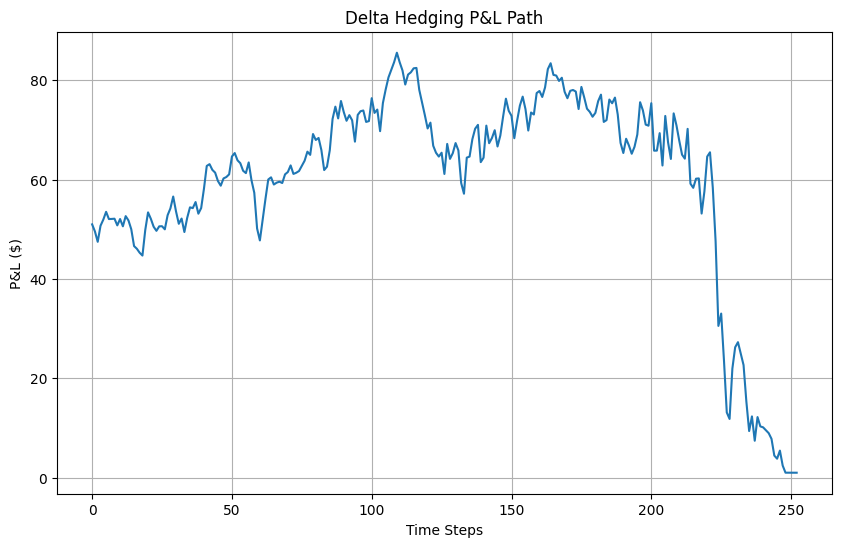

In [6]:
import AssetModels

import numpy as np
from scipy import stats
from math import log, sqrt, exp
import AssetModels

def d1(S0, K, T, r, sigma, q=0):
    if T == 0:
        return float('inf') if S0 > K else float('-inf') if S0 < K else 0.0
    return (log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))

def d2(S0, K, T, r, sigma, q=0):
    return d1(S0, K, T, r, sigma, q) - sigma * sqrt(T) if T != 0 else 0

def delta(S0, K, T, r, sigma, option_type, q=0):
    d1_val = d1(S0, K, T, r, sigma, q)
    if option_type == 'call':
        return stats.norm.cdf(d1_val)
    elif option_type == 'put':
        return stats.norm.cdf(d1_val) - 1

def gamma(S0, K, T, r, sigma):
    d1_val = d1(S0, K, T, r, sigma)
    return stats.norm.pdf(d1_val) / (S0 * sigma * sqrt(T))

def vega(S0, K, T, r, sigma):
    d1_val = d1(S0, K, T, r, sigma)
    return S0 * stats.norm.pdf(d1_val) * sqrt(T)

def theta(S0, K, T, r, sigma, option_type):
    d1_val = d1(S0, K, T, r, sigma)
    d2_val = d2(S0, K, T, r, sigma)
    return -S0 * stats.norm.pdf(d1_val) * sigma / (2 * sqrt(T)) - r * K * exp(-r * T) * stats.norm.cdf(d2_val) if option_type == 'call' else -S0 * stats.norm.pdf(d1_val) * sigma / (2 * sqrt(T)) + r * K * exp(-r * T) * stats.norm.cdf(-d2_val)

def rho(S0, K, T, r, sigma, option_type):
    d2_val = d2(S0, K, T, r, sigma)
    return K * T * exp(-r * T) * stats.norm.cdf(d2_val) if option_type == 'call' else -K * T * exp(-r * T) * stats.norm.cdf(-d2_val)

def price(S0, K, T, r, sigma, option_type, q=0):
    if option_type not in ['call', 'put']:
        raise ValueError("option_type must be 'call' or 'put'")
    if sigma <= 0 or T < 0 or K <= 0 or S0 <= 0:
        raise ValueError("Invalid parameters")
    d1_val = d1(S0, K, T, r, sigma, q)
    d2_val = d2(S0, K, T, r, sigma, q)
    if option_type == 'call':
        return S0 * exp(-q * T) * stats.norm.cdf(d1_val) - K * exp(-r * T) * stats.norm.cdf(d2_val)
    elif option_type == 'put':
        return K * exp(-r * T) * stats.norm.cdf(-d2_val) - S0 * exp(-q * T) * stats.norm.cdf(-d1_val)

def delta_hedge(S0, K, T, r, sigma, option_type, mu, dt, option_pos, path=None, sigma_h=None, sigma_a=None):
    sigma_h = sigma_h if sigma_h is not None else sigma
    sigma_a = sigma_a if sigma_a is not None else sigma

    S = AssetModels.GBM(S0, mu, sigma_a, T, dt) if path is None else np.array(path)
    option_price = price(S0, K, T, r, sigma, option_type)
    N = len(S)
    t = np.linspace(0, T, N)
    T_i = T - t

    d1_vals = np.where(
        T_i[:-1] == 0,
        np.where(S[:-1] > K, float('inf'), np.where(S[:-1] < K, float('-inf'), 0.0)),
        (np.log(S[:-1] / K) + (r + 0.5 * sigma_h ** 2) * T_i[:-1]) / (sigma_h * np.sqrt(T_i[:-1]))
    )
    d1_vals = np.append(
        d1_vals, 
        float('inf') if S[-1] > K else float('-inf') if S[-1] < K else 0.0
    )

    delta_vals = stats.norm.cdf(d1_vals) if option_type == 'call' else stats.norm.cdf(d1_vals) - 1

    delta_diff = np.diff(delta_vals, prepend=0)
    cashflows = delta_diff * option_pos * S
    comp_factors = np.exp(r * (T - t)) - 1
    interests = cashflows * comp_factors
    pnl = np.sum(interests) + np.sum(cashflows)

    if option_type == 'call' and S[-1] > K:
        pnl -= K * option_pos
    elif option_type == 'put' and S[-1] < K:
        pnl += K * option_pos

    return pnl * np.exp(-r * T) - option_price * option_pos

def dh_path(S0, K, T, r, sigma, option_type, mu, dt, option_pos, path=None, sigma_h=None, sigma_a=None):
    sigma_h = sigma_h if sigma_h is not None else sigma
    sigma_a = sigma_a if sigma_a is not None else sigma

    S = AssetModels.GBM(S0, mu, sigma_a, T, dt) if path is None else np.array(path)
    option_price = price(S0, K, T, r, sigma, option_type)
    N = len(S)
    t = np.linspace(0, T, N)
    T_i = T - t

    d1_vals = np.where(
        T_i[:-1] == 0,
        np.where(S[:-1] > K, float('inf'), np.where(S[:-1] < K, float('-inf'), 0.0)),
        (np.log(S[:-1] / K) + (r + 0.5 * sigma_h ** 2) * T_i[:-1]) / (sigma_h * np.sqrt(T_i[:-1]))
    )
    d1_vals = np.append(
        d1_vals, 
        float('inf') if S[-1] > K else float('-inf') if S[-1] < K else 0.0
    )

    delta_vals = stats.norm.cdf(d1_vals) if option_type == 'call' else stats.norm.cdf(d1_vals) - 1

    delta_diff = np.diff(delta_vals, prepend=0)
    cashflows = delta_diff * option_pos * S
    comp_factors = np.exp(r * (T - t)) - 1
    interests = cashflows * comp_factors
    pnl_path = np.cumsum(interests + cashflows)

    if option_type == 'call' and S[-1] > K:
        pnl_path[-1] -= K * option_pos
    elif option_type == 'put' and S[-1] < K:
        pnl_path[-1] += K * option_pos

    pnl_path -= option_price * option_pos
    pnl_path *= np.exp(-r * T)

    return pnl_path

# Example Usage:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.25
option_type = 'call'
mu = 0.05
dt = 1/252
option_pos = 1
path = None

pnl_path = dh_path(S0, K, T, r, sigma, option_type, mu, dt, option_pos, path)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(pnl_path)
plt.title("Delta Hedging P&L Path")
plt.xlabel("Time Steps")
plt.ylabel("P&L ($)")
plt.grid(True)
plt.show()

In [7]:
def portfolio_path_garch(S0, T, r, sigma0, mu, dt, positions, 
                        sigma0_garch, kappa, sigma_bar, alpha, jump_intensity, jump_mean, jump_std, strikes=None):
    """
    Simulates portfolio values and positions for stock, call, put, and cash securities using GARCH_with_jumps.

    Parameters:
        S0 (float): Initial stock price.
        T (float): Total time to maturity.
        r (float): Risk-free rate.
        sigma0 (float): Initial volatility for the GARCH model.
        mu (float): Drift of the stock.
        dt (float): Time step size.
        positions (dict): Dictionary of positions, e.g., 
                          {'positions': [0, 1, -1, 100], 'security': ['stock', 'call', 'put', 'cash']}.
        sigma0_garch, kappa, sigma_bar, alpha: GARCH parameters.
        jump_intensity, jump_mean, jump_std: Jump parameters for the GARCH model.
        strikes (list): Strike prices for the options, must correspond to positions in the 'call' and 'put' entries.

    Returns:
        dict: Contains arrays for values of each security and total portfolio value over time.
    """
    # Generate the GARCH_with_jumps price path
    S, t, sigma_t = GARCH_with_jumps(S0, mu, sigma0_garch, kappa, sigma_bar, alpha, T, dt, 
                                     jump_intensity, jump_mean, jump_std)

    # Extract position information
    positions_array = positions['positions']
    security_array = positions['security']
    if strikes is None:
        strikes = [S0] * len(positions_array)  # Default to initial stock price for all options
    
    num_steps = len(S)

    # Initialize arrays for each security's value over time
    stock_values = np.zeros(num_steps)
    call_values = np.zeros(num_steps)
    put_values = np.zeros(num_steps)
    cash_values = np.zeros(num_steps)

    # Account for initial position in cash
    initial_cash_adjustment = 0
    for i, security in enumerate(security_array):
        if security in ['call', 'put']:
            strike = strikes[i]
            # Calculate option price at initialization using the same method as below
            time_to_maturity = T
            d1 = (np.log(S[0] / strike) + (r + 0.5 * sigma0_garch ** 2) * time_to_maturity) / (sigma0_garch * np.sqrt(time_to_maturity))
            d2 = d1 - sigma0_garch * np.sqrt(time_to_maturity)
            option_price = (S[0] * stats.norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(d2)) if security == 'call' else \
                           (strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(-d2) - S[0] * stats.norm.cdf(-d1))
            initial_cash_adjustment -= positions_array[i] * option_price
        elif security == 'stock':
            initial_cash_adjustment -= positions_array[i] * S[0]
    cash_values[0] = positions_array[-1] + initial_cash_adjustment  # Adjust initial cash

    # Iterate through the time steps and calculate values
    for i, security in enumerate(security_array):
        position = positions_array[i]
        strike = strikes[i] if security in ['call', 'put'] else None

        if security == 'stock':
            stock_values = position * S

        elif security == 'call':
            # Handle option expiration and edge cases for T-t
            time_to_maturity = np.maximum(T - t, 0)
            d1 = np.where(
                time_to_maturity > 0,
                (np.log(S / strike) + (r + 0.5 * sigma_t ** 2) * time_to_maturity) / (sigma_t * np.sqrt(time_to_maturity)),
                -np.inf
            )
            d2 = d1 - sigma_t * np.sqrt(time_to_maturity)
            call_values = position * np.where(
                time_to_maturity > 0,
                S * stats.norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(d2),
                np.maximum(S - strike, 0)  # Payoff at expiration
            )

        elif security == 'put':
            # Handle option expiration and edge cases for T-t
            time_to_maturity = np.maximum(T - t, 0)
            d1 = np.where(
                time_to_maturity > 0,
                (np.log(S / strike) + (r + 0.5 * sigma_t ** 2) * time_to_maturity) / (sigma_t * np.sqrt(time_to_maturity)),
                -np.inf
            )
            d2 = d1 - sigma_t * np.sqrt(time_to_maturity)
            put_values = position * np.where(
                time_to_maturity > 0,
                strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1),
                np.maximum(strike - S, 0)  # Payoff at expiration
            )

        elif security == 'cash':
            cash_values = position * np.exp(r * t)

    # Calculate total portfolio value at each time step
    total_values = stock_values + call_values + put_values + cash_values

    # Return results as a dictionary
    return {
        'stock_values': stock_values,
        'call_values': call_values,
        'put_values': put_values,
        'cash_values': cash_values,
        'total_values': total_values
    }

# Example usage
S0 = 100
T = 1
r = 0.05
sigma0 = 0.25
mu = 0.05
dt = 1/252
positions = {
    'positions': [10, 5, -5, 1000],
    'security': ['stock', 'call', 'put', 'cash']
}
strikes = [None, 110, 90, None]  # Strike prices for options
sigma0_garch = 0.25
kappa = 0.1
sigma_bar = 0.2
alpha = 0.1
jump_intensity = 0.05
jump_mean = -0.02
jump_std = 0.1

results = portfolio_path_garch(S0, T, r, sigma0, mu, dt, positions, 
                               sigma0_garch, kappa, sigma_bar, alpha, 
                               jump_intensity, jump_mean, jump_std, strikes)

# Plot portfolio value over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results['total_values'], label='Total Portfolio Value')
plt.plot(results['stock_values'], label='Stock Value')
plt.plot(results['call_values'], label='Call Option Value')
plt.plot(results['put_values'], label='Put Option Value')
plt.plot(results['cash_values'], label='Cash Value')
plt.title("Portfolio Value Simulation with GARCH_with_jumps")
plt.xlabel("Time Steps")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'GARCH_with_jumps' is not defined

In [ ]:
<problem url_name="4655ac49229d42e2b8146ea002200b7d" copied_from_block="block-v1:MITx+15.435x+2T2022+type@problem+block@4655ac49229d42e2b8146ea002200b7d" upstream="null">
<script type="text/python">

"""
Notes to future editors:
  1) Randomization on EdX by student ID is imperfect, hence the need for the seednum calculation
  2) Rounding numbers also leads to strange errors, hence the need for the fround function
"""

### BOILERPLATE CODE ###
import math
import random
from typing import Tuple

# random seed according to student id
try:
  seednum = int(anonymous_student_id, 16)
except:
  seednum = 925668404
random.seed(seednum)

def fround(x: float) -&gt; float:
  """Corrects Python's rounding approach
  """
  xfrac, xint = math.modf(x)
  return xint + round(xfrac, 12)

def ffloat(x: float, n: int) -&gt; float:
  """Corrects Python's float trailing bias
  """
  return float(f"{fround(x):.{n}f}")

def fdisp(x: float, n: int) -&gt; str:
  """Returns n-digit display format
  """
  return f"{fround(x):,.{n}f}"

def f(x: float, n: int) -&gt; Tuple[float, str]:
  """Returns corrected float and display string of result
  """
  return ffloat(x, n), fdisp(x, n)


### PROBLEM CODE ###
shares_outstanding = ffloat(2e4, 0)
shares_outstanding_disp = f"{shares_outstanding:,.0f}"
price_per_share, price_per_share_disp = f(random.randint(145, 155), 2)
rf = ffloat(random.random()/50 + 0.01, 3)
rf_disp = f"{rf:.2%}"
sigma = ffloat(random.random()/10 + 0.3, 2)
sigma_disp = f"{sigma:.2%}"

# Old code not used in this problem
u =  math.exp(sigma)
d = 1/u

# S11 = S0 * u
# S12 = S0 * d
# S21 = S11 * u
# S22 = S11 * d
# S23 = S12 * d


u_bar =  1.25
d_bar = 0.8

S0 = price_per_share
S11 = S0 * u_bar
S12 = S0 * d_bar
S21 = S11 * u_bar
S22 = S11 * d_bar
S23 = S12 * d_bar

</script>
  <p>
    (a)(ii) Use those multipliers to assign a value to each node of the tree below.
  </p>
  <p>
    \[
      \begin{array}{lllll}
      \hline
      t=0   &amp;          &amp; t=1   &amp;          &amp; t=2    \\ \hline
      &amp;          &amp;       &amp;          &amp; S_{21} \\
      &amp;          &amp;       &amp; \nearrow &amp;        \\
      &amp;          &amp; S_{11} &amp;          &amp;        \\
      &amp; \nearrow &amp;       &amp; \searrow &amp;        \\
      S_{0} &amp;          &amp;       &amp;          &amp; S_{22} \\
      &amp; \searrow &amp;       &amp; \nearrow &amp;        \\
      &amp;          &amp; S_{12} &amp;          &amp;        \\
      &amp;          &amp;       &amp; \searrow &amp;        \\
      &amp;          &amp;       &amp;          &amp; S_{23} \\ \hline
      \end{array}
    \]
  </p>
  <numericalresponse answer="$S0">
    <p>\(S_{0}\)</p>
    <responseparam type="tolerance" default="2%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
  <numericalresponse answer="$S11">
    <p>\(S_{11}\)</p>
    <responseparam type="tolerance" default="2%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
  <numericalresponse answer="$S12">
    <p>\(S_{12}\)</p>
    <responseparam type="tolerance" default="2%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
  <numericalresponse answer="$S21">
    <p>\(S_{21}\)</p>
    <responseparam type="tolerance" default="2%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
  <numericalresponse answer="$S22">
    <p>\(S_{22}\)</p>
    <responseparam type="tolerance" default="2%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
  <numericalresponse answer="$S23">
    <p>\(S_{23}\)</p>
    <responseparam type="tolerance" default="2%" name="tol" description="Numerical Tolerance"/>
    <textline size="10" trailing_text="dollars"/>
  </numericalresponse>
</problem>
  


In [52]:
S0 = 0.96
r_eur = 0.01
r_usd = .034
T = 3/12

# Calculate the forward exchange rate
F = S0 * np.exp((r_eur - r_usd) * T)
F

0.9542572454917778

In [51]:


S = 100
K1,K2 = 100,110
r = 5.00/100
delta = 0/100
T = 1

from scipy.stats import norm

def done(S,K,T,r,delta,sigma):
  """calculate done
  """
  return (math.log(S/K)+(r-delta+sigma**2/2.)*T)/(sigma*math.sqrt(T))

def dtwo(S,K,T,r,delta,sigma):
  """calculate dtwo
  """
  return done(S,K,T,r,delta,sigma)-sigma*math.sqrt(T)

def call(S,K,T,r,delta,sigma):
  """calculate call
  """
  return S*math.exp(-delta*T)*norm.cdf(done(S,K,T,r,delta,sigma))-K*math.exp(-r*T)*norm.cdf(dtwo(S,K,T,r,delta,sigma))

def put(S,K,T,r,delta,sigma):
  """calculate put
  """
  return K*math.exp(-r*T)*norm.cdf(-dtwo(S,K,T,r,delta,sigma))-S*math.exp(-delta*T)*norm.cdf(-done(S,K,T,r,delta,sigma))

c1 = 9.330250
c2 = 6.436232

def vega(S,K,T,r,delta,sigma):
  """calculate vega
  """
  return S*math.sqrt(T)*norm.pdf(done(S,K,T,r,delta,sigma))

def impvol(S,K,T,r,delta,optionprice,tol=1e-5,maxiter=1e3):
  """calculate implied volatility
  """
  sigma = .5
  for i in range(int(maxiter)):
    diff = optionprice - call(S,K,T,r,delta,sigma)
    if abs(diff) < tol:
      break
    sigma = sigma + diff/vega(S,K,T,r,delta,sigma)
  return sigma

sigma1 = impvol(S,K1,T,r,delta,c1)
sigma2 = impvol(S,K2,T,r,delta,c2)

### Solution Block

sol_a1,sol_a1_disp = f6(sigma1)
sol_a2,sol_a2_disp = f6(sigma2)

sol_a1, sol_a2

(0.17, 0.21)

0.5